In [9]:
import folium
import pandas as pd
import numpy as np
import os
import json
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt

In [2]:
def read_csv(filename):
    df = pd.read_csv(filename)
    NewLap_idx = df[df.Time == 'New Lap'].index
    df.drop('heartratebpm/value',axis=1, inplace=True)
    df.dropna(how='any',axis=0, inplace=True)
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')
    df['Time'] = df['Time'].apply(lambda x: dateparse(x))
    df['dist'] = \
        haversine_np(df.LongitudeDegrees.shift(), df.LatitudeDegrees.shift(),
                     df.loc[1:, 'LongitudeDegrees'], df.loc[1:, 'LatitudeDegrees'])
    df['cum_dis'] = df.dist.cumsum()
    df['DeltaTime'] = (df.Time - df.Time.shift()).dt.seconds
    df['Speed'] = df.apply(lambda x: x['dist']/x['DeltaTime']*3600 if x['DeltaTime'] else np.NaN, axis=1)
    df['DeltaTime'] = (df.Time - df.Time.shift()).dt.seconds
    df['DeltaAltitude'] = df.AltitudeMeters - df.AltitudeMeters.shift()
    return df, NewLap_idx

In [3]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [19]:
path = 'data/csv/'
allFiles = os.listdir(path)
frame = pd.DataFrame(columns=('Date', 'Filename', 'Kilometers', 'Speed', 'Time', 'Climb', 'Lat', 'Long', 'Adress'))
dict_df = dict()
dict_newlap = dict()
for i, file in enumerate(allFiles):
    df, newlap = read_csv(path + file)
    dict_df[df['Time'][0].strftime("%Y-%m-%d")] = df
    dict_newlap[df['Time'][0].strftime("%Y-%m-%d")] = newlap
    geolocator = Nominatim()
    location = geolocator.reverse(str(df.LatitudeDegrees.mean()) + "," + str(df.LongitudeDegrees.mean()))[0]
    frame.loc[i] = [df['Time'][0], file, df.cum_dis.max(), df.Speed.mean(), df.DeltaTime.sum()/60,
                    df['DeltaAltitude'][df['DeltaAltitude'] > 0].sum(),
                    df.LatitudeDegrees.mean(), df.LongitudeDegrees.mean(), location]

In [20]:
dict_df['2016-10-08'].head()

,Time,LatitudeDegrees,LongitudeDegrees,AltitudeMeters,dist,cum_dis,DeltaTime,Speed,DeltaAltitude
0,2016-10-08 05:20:17,36.460728,25.390005,194.0,NaN,NaN,NaN,NaN,NaN
1,2016-10-08 05:20:18,36.460728,25.390005,195.0,0.000000,0.000000,1.0,0.000000,1.0
2,2016-10-08 05:20:19,36.460728,25.390005,195.0,0.000000,0.000000,1.0,0.000000,0.0
3,2016-10-08 05:20:20,36.460730,25.390005,195.0,0.000222,0.000222,1.0,0.800101,0.0
4,2016-10-08 05:20:20,36.460730,25.390005,195.0,0.000000,0.000222,0.0,NaN,0.0


In [26]:
mean_lat = np.mean([i[0] for i in [[float(v.LatitudeDegrees), float(v.LongitudeDegrees)] for k,v in dict_df['2016-10-08'].iterrows()]])
mean_long = np.mean([i[1] for i in [[float(v.LatitudeDegrees), float(v.LongitudeDegrees)] for k,v in dict_df['2016-10-08'].iterrows()]])

m = folium.Map(location=[mean_lat, mean_long ], zoom_start=13, tiles='OpenStreetMap')
folium.PolyLine([[float(v.LatitudeDegrees), float(v.LongitudeDegrees)] for k,v in dict_df['2016-10-08'].iterrows()],
                color='blue', opacity=1).add_to(m)
for i in dict_newlap['2016-10-08']:
    folium.Marker([dict_df['2016-10-08'].iloc[i-len(dict_newlap['2016-10-08'])]['LatitudeDegrees'], 
                   dict_df['2016-10-08'].iloc[i-len(dict_newlap['2016-10-08'])]['LongitudeDegrees'] ],
                  popup=str(i)).add_to(m)
m

In [29]:
m.save('output/santorini.html')

### Altitude vs Speed

In [32]:
df_resampled = pd.concat([dict_df['2016-10-08'][['Speed', 'AltitudeMeters']].rolling(window=10).mean(), dict_df['2016-10-08']['Time']], axis=1).resample('30s', on='Time').mean().reset_index()

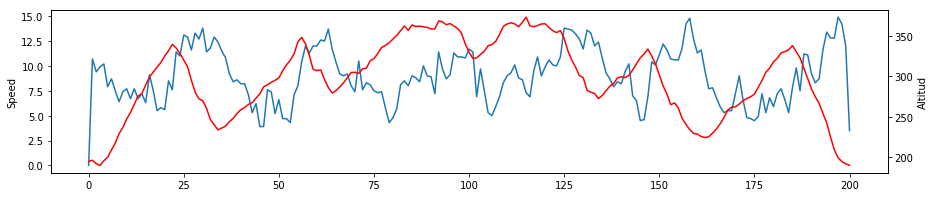

In [55]:
plt.figure(figsize=(15,3))
ax1 = plt.axes()
ax2 = ax1.twinx()
ax1.plot(df_resampled['Speed'].fillna(0).round(1).values.tolist())
ax2.plot(df_resampled['AltitudeMeters'].fillna(0).round(1).values.tolist(), 'r')
ax1.set_ylabel('Speed')
ax2.set_ylabel('Altitud')
plt.show()

## Distance interval

In [59]:
df_interval = dict_df['2016-10-08'].groupby(dict_df['2016-10-08']['cum_dis'].apply(lambda x: np.ceil(x))).agg({'DeltaTime' : sum, 'Speed': np.mean, 'DeltaAltitude' : np.sum}).reset_index()

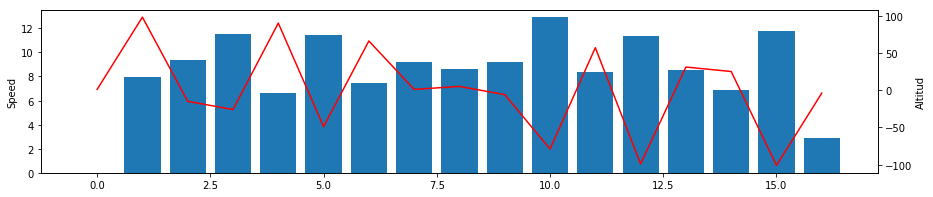

In [75]:
plt.figure(figsize=(15,3))
ax1 = plt.axes()
ax2 = ax1.twinx()
ax1.set_ylabel('Speed')
ax2.set_ylabel('Altitud')
ax2.plot(df_interval.cum_dis, df_interval.DeltaAltitude, color='r')
ax1.bar(df_interval.cum_dis, df_interval.Speed)
plt.show()

In [156]:
df_interval

,cum_dis,DeltaTime,Speed,DeltaAltitude
0,0.0,2.0,0.000000,1.0
1,1.0,451.0,7.988852,98.0
2,2.0,385.0,9.330590,-15.0
3,3.0,313.0,11.524092,-26.0
4,4.0,546.0,6.600975,90.0
5,5.0,314.0,11.455841,-49.0
6,6.0,485.0,7.432455,66.0
7,7.0,391.0,9.187743,1.0
8,8.0,419.0,8.592033,5.0
9,9.0,390.0,9.245032,-6.0


## Altitude distance from min to max 

In [170]:
list_df[number]['AltitudeMeters'].max() - list_df[number]['AltitudeMeters'].min()

189.0

## Cumulated climb altitude

In [178]:
list_df[number]['DeltaAltitude'][list_df[number]['DeltaAltitude'] > 0].sum()

1486.0

## Mean speed

In [183]:
list_df[number]['Speed'].mean()

9.0038812861360356

# Export to csv

In [76]:
with open('output/satorini.json', 'w') as outfile:
    json.dump({'AltSpeed': {'Speed': df_resampled['Speed'].fillna(0).round(1).values.tolist(),
               'Altitude': df_resampled['AltitudeMeters'].round(1).values.tolist(),
               'Time': df_resampled['Time'].apply(lambda d: "%.2d:%.2d:%.2d" % ((d - df_resampled['Time'][0]).seconds//3600,((d - df_resampled['Time'][0]).seconds//60)%60, (d - df_resampled['Time'][0]).seconds%60)).values.tolist()
                },
               'Interval': {'Speed': df_interval['Speed'].fillna(0).round(2).values.tolist(),
                            'Altitude': df_interval['DeltaAltitude'].fillna(0).round(2).values.tolist(),
                            'Distance': df_interval['cum_dis'].fillna(0).round(0).values.tolist()
                           }
              }, outfile, indent=1)